In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# generate some data
mu_0 = -5
sigma_0 = 3
mu_1 = 3
sigma_1 = 2

n_clips = 5000
n_pos = 400

# generate data
scores = np.zeros(n_clips)
labels = np.zeros(n_clips)
scores[:n_pos] = np.random.normal(mu_1, sigma_1, n_pos)
labels[:n_pos] = 1
scores[n_pos:] = np.random.normal(mu_0, sigma_0, n_clips - n_pos)
labels[n_pos:] = 0

# make a labeling weighting. Try 1/rank
df = pd.DataFrame({'score': scores, 'label': labels})
df = df.sort_values("score", ascending=False)
df["weighting"] = 1/(1 + np.arange(len(df)))

# shuffle them just to remove any ordering
df = df.sample(frac=1)

# ensure labels are integers
df["label"] = df["label"].astype(int)

n_labeled = 50

# sample according to the weighting
labeled = df.sample(n_labeled, weights="weighting")
unlabeled = df.drop(labeled.index)

# normalize the labeled weights
labeled["weighting"] = labeled["weighting"] / labeled["weighting"].sum()

# make the data dictionary
data = {'N_labeled': len(labeled), 
        'N_unlabeled': len(unlabeled), 
        'scores_labeled': labeled['score'].values, 
        'scores_unlabeled': unlabeled['score'].values,
        'sampling_weight': labeled["weighting"].values,
        'labels': labeled["label"].values}

# make the data


Number of positives in labeled data: 31
proportion of positives in labeled data: 0.62
proportion of positives in all data: 0.08


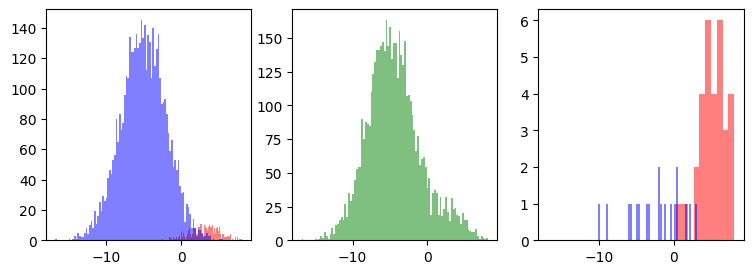

In [182]:
# plot the histogram of scores
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
pos = df[df['label'] == 1]
neg = df[df['label'] == 0]
ax[0].hist(pos['score'], bins=100, alpha=0.5, label='pos', color='red')
ax[0].hist(neg['score'], bins=100, alpha=0.5, label='neg', color='blue')
ax[1].hist(df['score'], bins=100, alpha=0.5, label='all', color='green')
ax[2].hist(labeled[labeled["label"] ==1]['score'], bins=10, alpha=0.5, label='labeled', color='red')
ax[2].hist(labeled[labeled["label"] ==0]['score'], bins=50, alpha=0.5, label='unlabeled', color='blue')
print(f"Number of positives in labeled data: {np.sum(labeled['label'])}")
print(f"proportion of positives in labeled data: {np.mean(labeled['label'])}")
print(f"proportion of positives in all data: {np.mean(df['label'])}")

In [130]:
#import cmdstanpy and use the stan model
import cmdstanpy
file = "weighted_sample_gmm.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)

In [ ]:
# fit the model
fit = model.sample(data=data, chains=, iter_warmup=250, iter_sampling=250)

13:07:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:07:51 - cmdstanpy - INFO - CmdStan done processing.
13:07:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'weighted_sample_gmm.stan', line 29, column 12 to line 31, column 86)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'weighted_sample_gmm.stan', line 29, column 12 to line 31, column 86)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'weighted_sample_gmm.stan', line 29, column 12 to line 31, column 86)
Consider re-running with show_console=True if the above output is unclear!
13:07:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (1.2%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [64]:
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-13950.90000,0.435938,2.140150,-13954.900000,-13950.40000,-13948.20000,24.10130,1.63376,1.09185
mu[1],-4.68349,0.001870,0.041944,-4.754090,-4.68286,-4.61524,502.83200,34.08570,1.00963
mu[2],3.06550,0.164751,1.593370,-0.640515,3.61797,4.51547,93.53520,6.34051,1.06356
sigma[1],3.01097,0.001143,0.027229,2.965600,3.01105,3.05605,567.10200,38.44240,1.00089
sigma[2],1.73639,0.223312,1.117500,0.661475,1.31963,4.21628,25.04210,1.69754,1.08486
theta,0.00305,0.000110,0.001430,0.001360,0.00274,0.00569,169.47371,11.48819,1.01573
n_pos_pred,14.18500,0.537490,6.913220,7.000000,13.00000,28.00000,165.43010,11.21408,1.01942


In [141]:
# now compare it to regular gmm model
file = "gmm.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)
fit = model.sample(data=data, chains=4, iter_warmup=250, iter_sampling=250)
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()

15:16:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:16:51 - cmdstanpy - INFO - CmdStan done processing.
15:16:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'gmm.stan', line 27, column 12 to line 29, column 86)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'gmm.stan', line 27, column 12 to line 29, column 86)
Consider re-running with show_console=True if the above output is unclear!


In [216]:
# try with the GP model
#import cmdstanpy and use the stan model
file = "GP.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)

16:42:36 - cmdstanpy - INFO - compiling stan file /Users/LOF19/Dev/stan_models/GP.stan to exe file /Users/LOF19/Dev/stan_models/GP
16:42:53 - cmdstanpy - INFO - compiled model executable: /Users/LOF19/Dev/stan_models/GP


In [217]:
# subset the data so we can fit the gp
data_gp = data.copy()

# fit the model
fit = model.sample(data=data_gp, chains=1, iter_warmup=500, iter_sampling=500, show_console=True)

16:42:53 - cmdstanpy - INFO - Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 500
Chain [1] num_warmup = 500
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.8 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /var/folders/_s/zm3gz4x52glfbflc25_3rp3w0000gq/T/tmpfck_tgys/mpwf1xy0.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [

16:43:01 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 4.143 seconds (Warm-up)
Chain [1] 3.609 seconds (Sampling)
Chain [1] 7.752 seconds (Total)
Chain [1] 
Chain [1] 


In [218]:
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-86.147600,0.605354,8.251810,-100.159000,-85.691100,-73.02500,185.814000,51.486300,0.998727
rho,0.466439,0.035382,0.442604,0.120197,0.335246,1.25783,156.479000,43.358000,1.004240
alpha,0.935501,0.034377,0.565897,0.110223,0.888232,1.99189,270.979000,75.084400,1.001400
eta[1],-0.444869,0.035321,0.961008,-2.022680,-0.430531,1.16815,740.273000,205.119000,0.998257
eta[2],-0.054315,0.034933,0.995908,-1.694630,-0.041350,1.50456,812.743000,225.199000,0.998705
...,...,...,...,...,...,...,...,...,...
f[147],7.419190,0.046613,1.089030,5.764320,7.342510,9.10884,545.845000,151.245000,0.999909
f[148],7.646600,0.046049,1.065750,5.745620,7.615030,9.33173,535.639000,148.417000,0.999430
f[149],7.789810,0.040118,1.044680,5.986960,7.829240,9.40471,678.100000,187.891000,0.998770
f[150],8.027780,0.045755,1.072340,6.200550,8.074650,9.74665,549.264000,152.193000,0.999079


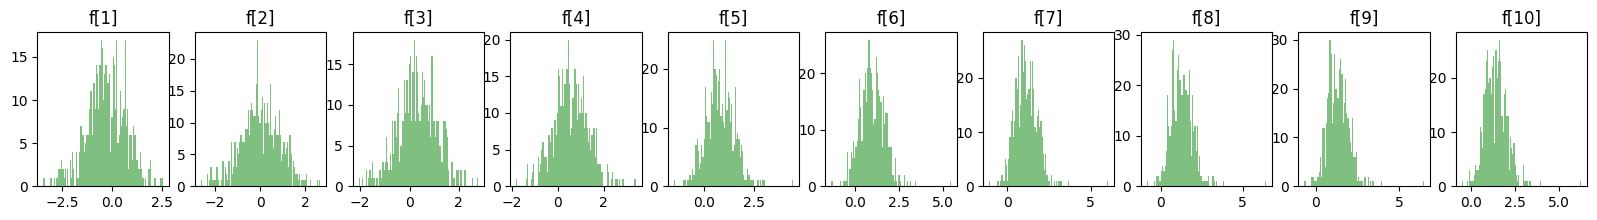

In [210]:
# plot histograms of f[1], f[11], f[21], f[31], f[41], f[51], f[61], f[71], f[81], f[91]
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].hist(samples[f"f[{i+1}]"], bins=100, alpha=0.5, label=f"f[{i+1}]", color='green')
    ax[i].set_title(f"f[{i+1}]")